# Data Science Project: Persistency of Drug

## Notebook about data clensing and transformation

## Load the dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests as rq
from io import BytesIO

url = "https://raw.githubusercontent.com/EniasVontas/DataSets/main/ntm_dataset.xlsx"
data = rq.get(url).content
data = pd.read_excel(BytesIO(data))

data.info()
data.groupby(["Persistency_Flag"]).Persistency_Flag.count()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424 entries, 0 to 3423
Data columns (total 69 columns):
 #   Column                                                              Non-Null Count  Dtype 
---  ------                                                              --------------  ----- 
 0   Ptid                                                                3424 non-null   object
 1   Persistency_Flag                                                    3424 non-null   object
 2   Gender                                                              3424 non-null   object
 3   Race                                                                3424 non-null   object
 4   Ethnicity                                                           3424 non-null   object
 5   Region                                                              3424 non-null   object
 6   Age_Bucket                                                          3424 non-null   object
 7   Ntm_Speciality          

Persistency_Flag
Non-Persistent    2135
Persistent        1289
Name: Persistency_Flag, dtype: int64

#### Split Dataset
####  Label the target variable and drop ID variable

In [2]:
data = data.drop(['Ptid'],axis=1)
X = data.drop(['Persistency_Flag'],axis=1)

y=data['Persistency_Flag']

#### Split the dataset into Train and Test

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape) 

Train (2739, 67) (2739,)
Test (685, 67) (685,)


In [4]:
# We encode the target variable
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)

le.classes_
y_train=le.transform(y_train)

y_test = le.transform(y_test)

####     Choose 'object' and 'non-object' columns

In [5]:
data_numeric_train = X_train.select_dtypes(exclude=['object'])
data_numeric_test = X_test.select_dtypes(exclude=['object'])
data_obj_train = X_train.select_dtypes(include=['object']).copy()
data_obj_test = X_test.select_dtypes(include=['object']).copy()

#### We keep the indices of the Train and Test sets, because they will be removed later, during Imputation 

In [6]:
indices_train = data_numeric_train.index
indices_test = data_numeric_test.index

#### We check some variables for Unknown values

In [7]:
data_obj_train.groupby(["Ntm_Speciality"]).Ntm_Speciality.count()

Ntm_Speciality
CARDIOLOGY                                                          20
CLINICAL NURSE SPECIALIST                                            1
EMERGENCY MEDICINE                                                   1
ENDOCRINOLOGY                                                      353
GASTROENTEROLOGY                                                     2
GENERAL PRACTITIONER                                              1236
GERIATRIC MEDICINE                                                   2
HEMATOLOGY & ONCOLOGY                                               11
HOSPICE AND PALLIATIVE MEDICINE                                      2
NEPHROLOGY                                                           3
NEUROLOGY                                                            1
NUCLEAR MEDICINE                                                     1
OBSTETRICS & OBSTETRICS & GYNECOLOGY & OBSTETRICS & GYNECOLOGY       1
OBSTETRICS AND GYNECOLOGY                                     

In [8]:
data_obj_train.groupby(["Ntm_Specialist_Flag"]).Ntm_Specialist_Flag.count()

Ntm_Specialist_Flag
Others        1633
Specialist    1106
Name: Ntm_Specialist_Flag, dtype: int64

In [9]:
data_obj_train.groupby(["Ntm_Speciality_Bucket"]).Ntm_Speciality_Bucket.count()

Ntm_Speciality_Bucket
Endo/Onc/Uro                  556
OB/GYN/Others/PCP/Unknown    1706
Rheum                         477
Name: Ntm_Speciality_Bucket, dtype: int64

In [10]:
data_obj_train.groupby(["Adherent_Flag"]).Adherent_Flag.count()

Adherent_Flag
Adherent        2599
Non-Adherent     140
Name: Adherent_Flag, dtype: int64

In [11]:
data_obj_train.groupby(["Tscore_Bucket_During_Rx"]).Tscore_Bucket_During_Rx.count()

Tscore_Bucket_During_Rx
<=-2.5      805
>-2.5       711
Unknown    1223
Name: Tscore_Bucket_During_Rx, dtype: int64

In [12]:
data_obj_train.groupby(["Change_T_Score"]).Change_T_Score.count()

Change_T_Score
Improved       77
No change    1299
Unknown      1223
Worsened      140
Name: Change_T_Score, dtype: int64

In [13]:
data_obj_train.groupby(["Change_Risk_Segment"]).Change_Risk_Segment.count()

Change_Risk_Segment
Improved       17
No change     820
Unknown      1802
Worsened      100
Name: Change_Risk_Segment, dtype: int64

#### We drop the two columns, because Count of Risks is a linear combination of all other Risk variables
#### and Change in Risk Segment has about 65% missing values

In [14]:
data_numeric_train = data_numeric_train.drop('Count_Of_Risks',axis=1)
data_numeric_test = data_numeric_test.drop('Count_Of_Risks',axis=1)

data_obj_train = data_obj_train.drop(['Change_Risk_Segment'],axis=1)

data_obj_test = data_obj_test.drop(['Change_Risk_Segment'],axis=1)

## Exploratory Data Analysis

### Demographics plots

### Gender

In [15]:
y_train = pd.DataFrame(y_train,columns=["Persistency_Flag"])
y_train.index = indices_train
# we rename our dataframe 'data' that contains the 'Train' set data frames 
data = pd.concat([data_obj_train,y_train],axis=1)

data.groupby(["Gender",'Persistency_Flag']).Persistency_Flag.count()

Gender  Persistency_Flag
Female  0                   1620
        1                    962
Male    0                     93
        1                     64
Name: Persistency_Flag, dtype: int64

C:\Users\Enias\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


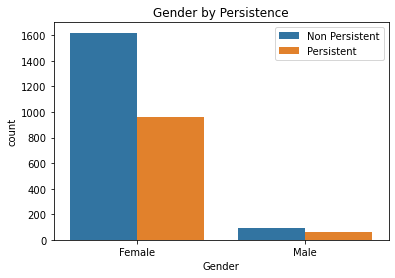

In [16]:
sns.countplot(data['Gender'],hue=data['Persistency_Flag'])
plt.title("Gender by Persistence")
plt.legend(labels = ["Non Persistent","Persistent"])
plt.show()

### Race

In [17]:
data.groupby(["Race",'Persistency_Flag']).Persistency_Flag.count()

Race              Persistency_Flag
African American  0                     53
                  1                     25
Asian             0                     40
                  1                     32
Caucasian         0                   1570
                  1                    943
Other/Unknown     0                     50
                  1                     26
Name: Persistency_Flag, dtype: int64

C:\Users\Enias\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


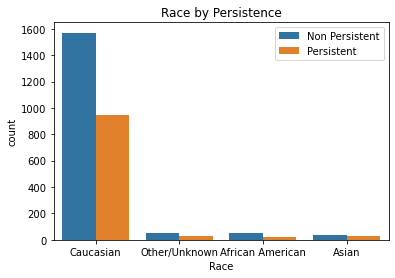

In [18]:
sns.countplot(data['Race'],hue=data['Persistency_Flag'])
plt.title("Race by Persistence")
plt.legend(labels = ["Non Persistent","Persistent"])
plt.show()

### Ethnicity

In [19]:
data.groupby(["Ethnicity",'Persistency_Flag']).Persistency_Flag.count()

Ethnicity     Persistency_Flag
Hispanic      0                     48
              1                     26
Not Hispanic  0                   1612
              1                    976
Unknown       0                     53
              1                     24
Name: Persistency_Flag, dtype: int64

C:\Users\Enias\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


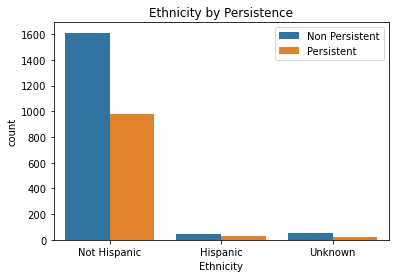

In [20]:
sns.countplot(data['Ethnicity'],hue=data['Persistency_Flag'])
plt.title("Ethnicity by Persistence")
plt.legend(labels = ["Non Persistent","Persistent"])
plt.show()


### Region

In [21]:
data.groupby(["Region",'Persistency_Flag']).Persistency_Flag.count()

Region         Persistency_Flag
Midwest        0                   735
               1                   363
Northeast      0                   112
               1                    76
Other/Unknown  0                    28
               1                    18
South          0                   613
               1                   378
West           0                   225
               1                   191
Name: Persistency_Flag, dtype: int64

C:\Users\Enias\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


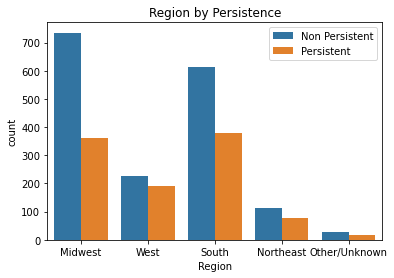

In [22]:
sns.countplot(data['Region'],hue=data['Persistency_Flag'])
plt.title("Region by Persistence")
plt.legend(labels = ["Non Persistent","Persistent"])
plt.show()

### Age Group

In [23]:
data.groupby(["Age_Bucket",'Persistency_Flag']).Persistency_Flag.count()

Age_Bucket  Persistency_Flag
55-65       0                   382
            1                   209
65-75       0                   520
            1                   340
<55         0                    85
            1                    48
>75         0                   726
            1                   429
Name: Persistency_Flag, dtype: int64

C:\Users\Enias\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


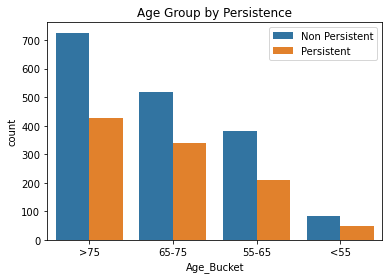

In [24]:
sns.countplot(data['Age_Bucket'],hue=data['Persistency_Flag'])
plt.title("Age Group by Persistence")
plt.legend(labels = ["Non Persistent","Persistent"])
plt.show()

In [25]:
### IDN indicator

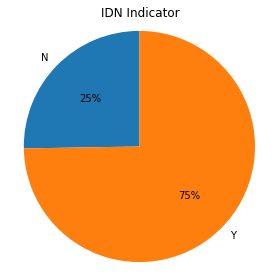

In [26]:
counts = data.groupby(["Idn_Indicator"]).Idn_Indicator.count()
counts.plot.pie(y=counts.index,autopct='%1.0f%%',startangle=90,label="", title="IDN Indicator",figsize=(4,4))
plt.axis('equal')
plt.tight_layout()
plt.show()

In [27]:
### Physician Attriutes Plots

<AxesSubplot:xlabel='Ntm_Speciality_Bucket'>

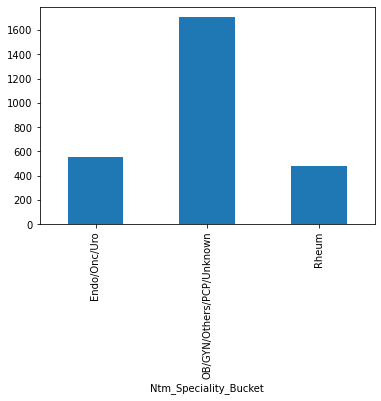

In [28]:
data.groupby(["Ntm_Speciality_Bucket"]).Ntm_Speciality_Bucket.count().plot(kind='bar')

In [29]:
data.groupby(["Ntm_Speciality"]).Ntm_Speciality.count()

Ntm_Speciality
CARDIOLOGY                                                          20
CLINICAL NURSE SPECIALIST                                            1
EMERGENCY MEDICINE                                                   1
ENDOCRINOLOGY                                                      353
GASTROENTEROLOGY                                                     2
GENERAL PRACTITIONER                                              1236
GERIATRIC MEDICINE                                                   2
HEMATOLOGY & ONCOLOGY                                               11
HOSPICE AND PALLIATIVE MEDICINE                                      2
NEPHROLOGY                                                           3
NEUROLOGY                                                            1
NUCLEAR MEDICINE                                                     1
OBSTETRICS & OBSTETRICS & GYNECOLOGY & OBSTETRICS & GYNECOLOGY       1
OBSTETRICS AND GYNECOLOGY                                     

In [30]:
data.groupby(["Ntm_Specialist_Flag"]).Ntm_Specialist_Flag.count()

Ntm_Specialist_Flag
Others        1633
Specialist    1106
Name: Ntm_Specialist_Flag, dtype: int64

In [31]:
counts=data.groupby(["Ntm_Speciality",'Ntm_Specialist_Flag']).Ntm_Speciality.count().unstack('Ntm_Specialist_Flag').fillna(0)
counts = counts.sort_values(['Others','Specialist'],ascending=False)

# we rename a column that seems to offer the same information as the name 'OBSTETRICS AND GYNECOLOGY'
counts=counts.rename({'OBSTETRICS & OBSTETRICS & GYNECOLOGY & OBSTETRICS & GYNECOLOGY':'OBSTETRICS AND GYNECOLOGY'})
labels = list(counts.index)

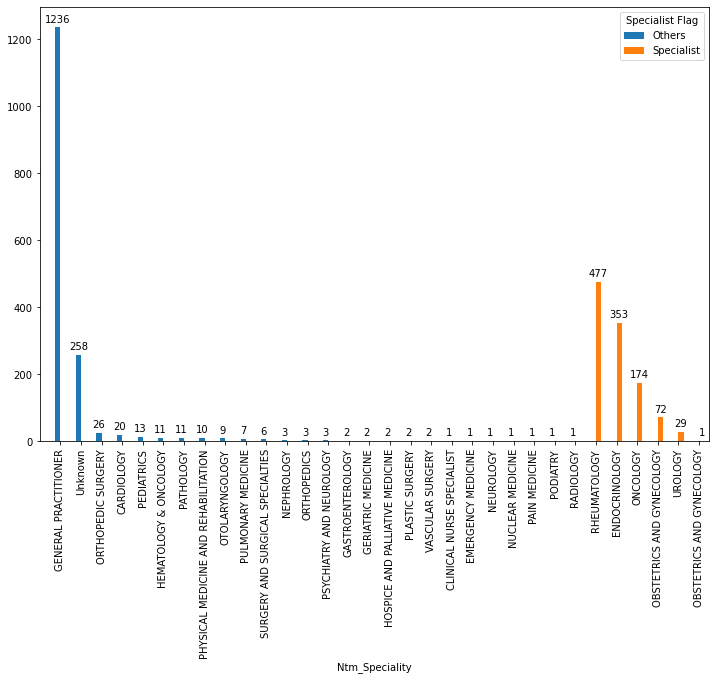

In [32]:
X_axis = np.arange(len(labels))
ax = counts.plot(stacked=False, kind='bar', figsize=(12, 8), rot='horizontal')

plt.xticks(X_axis, rotation=90)
plt.xlim(left=-1)
for rect in ax.patches:
    
    height = rect.get_height()
    
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
       
    label_text = f'{height:.0f}'  
        
    label_x = x + width / 2
    label_y = y + height + 25
    
    if height > 0:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=10)
    
ax.legend(title = 'Specialist Flag')   
plt.show()

### T Score prior to NTM

In [33]:
data.groupby(["Tscore_Bucket_Prior_Ntm"]).Tscore_Bucket_Prior_Ntm.count()

Tscore_Bucket_Prior_Ntm
<=-2.5    1183
>-2.5     1556
Name: Tscore_Bucket_Prior_Ntm, dtype: int64

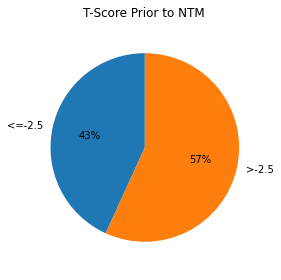

In [34]:
counts = data.groupby(["Tscore_Bucket_Prior_Ntm"]).Tscore_Bucket_Prior_Ntm.count()
counts.plot.pie(y=counts.index,autopct='%1.0f%%',startangle=90,label="", title="T-Score Prior to NTM",figsize=(4,4))
plt.axis('equal')
plt.tight_layout()
plt.show()

### Fragility Fracture

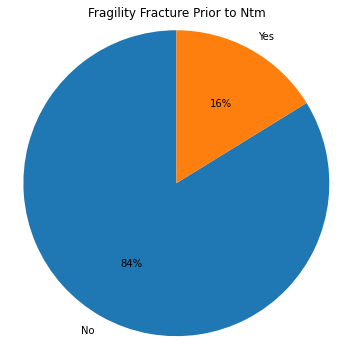

In [35]:
counts = data.groupby(["Frag_Frac_Prior_Ntm"]).Frag_Frac_Prior_Ntm.count()
counts.plot.pie(y=counts.index,autopct='%1.0f%%',startangle=90,ylabel="",labels=["No","Yes"], title="Fragility Fracture Prior to Ntm",figsize=(5,5))
plt.axis('equal')
plt.tight_layout()
plt.show()

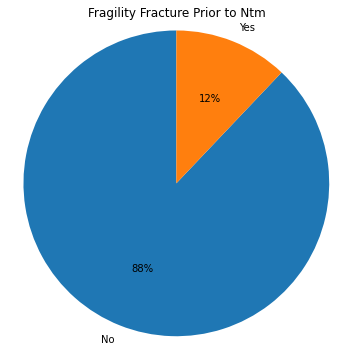

In [36]:
counts = data.groupby(["Frag_Frac_During_Rx"]).Frag_Frac_During_Rx.count()
counts.plot.pie(y=counts.index,autopct='%1.0f%%',startangle=90,ylabel="",labels=["No","Yes"], title="Fragility Fracture Prior to Ntm",figsize=(5,5))
plt.axis('equal')
plt.tight_layout()
plt.show()

### Glucocorticoids

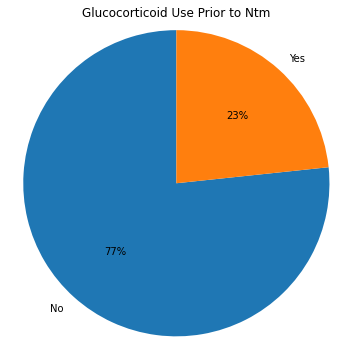

In [37]:
counts = data.groupby(["Gluco_Record_Prior_Ntm"]).Gluco_Record_Prior_Ntm.count()
counts.plot.pie(y=counts.index,autopct='%1.0f%%',startangle=90,ylabel="",labels=["No","Yes"], title="Glucocorticoid Use Prior to Ntm",figsize=(5,5))
plt.axis('equal')
plt.tight_layout()
plt.show()


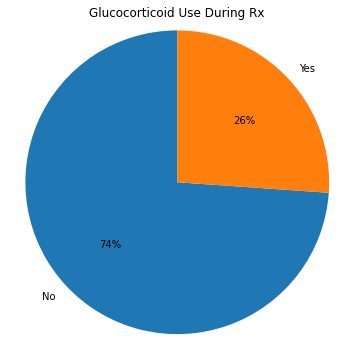

In [38]:
counts = data.groupby(["Gluco_Record_During_Rx"]).Gluco_Record_During_Rx.count()
counts.plot.pie(y=counts.index,autopct='%1.0f%%',startangle=90,ylabel="",labels=["No","Yes"], title="Glucocorticoid Use During Rx",figsize=(5,5))
plt.axis('equal')
plt.tight_layout()
plt.show()

### Risk Factors plot

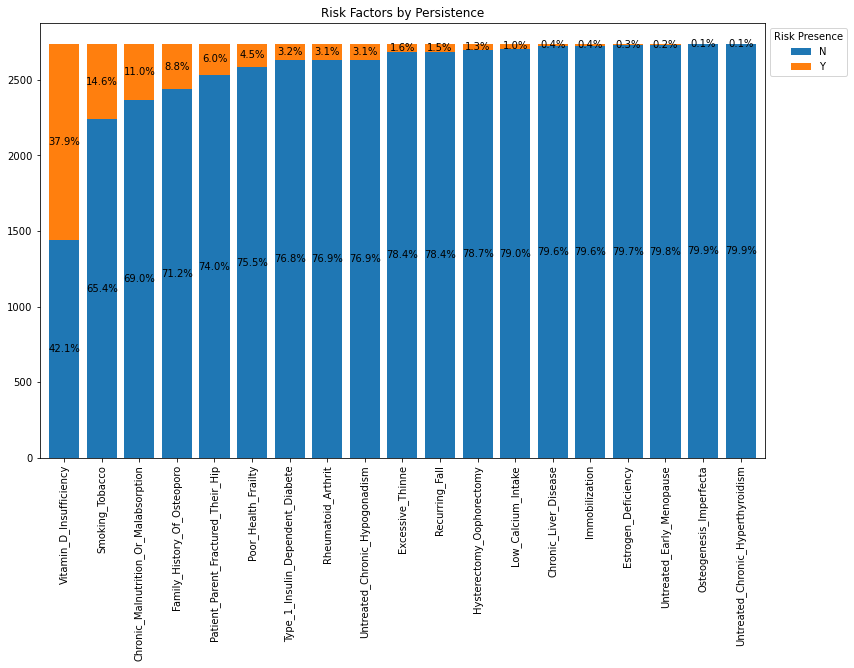

In [39]:

risk_factor_data = data.columns[45:64]
risk_data = data.iloc[:,45:64]

counts = pd.DataFrame()
for x in risk_data[0:len(risk_data)]:
    counts[x]=risk_data.groupby([x]).size().to_frame()
    
# we remove the word 'Risk' in front of every category to save some space on the end plot    
counts = counts.rename(columns = lambda x: x.strip('Risk'))
counts = counts.rename(columns = lambda x: x.strip('_'))

counts = counts.transpose()
counts = counts.sort_values('Y',ascending=False)

labels = list(counts.index)

X_axis = np.arange(len(labels))
ax = counts.plot(stacked=True, kind='bar',width=0.8, figsize=(13, 8), rot='horizontal')

plt.xticks(X_axis, labels,rotation=90)
for rect in ax.patches:
    
    height = rect.get_height()
    
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    
    label_text = f'{round((height/3424)*100,1)}%'  
    
    
    label_x = x + width / 2
    label_y = y + height / 2
    
    
    if height > 0:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=10)
    
ax.legend(title = 'Risk Presence',bbox_to_anchor=(1.0, 1.0))  
plt.title("Risk Factors by Persistence")
plt.show()

### Injectable Experience

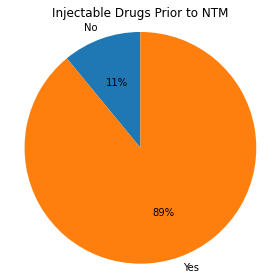

In [40]:
counts = data.groupby(["Injectable_Experience_During_Rx"]).Injectable_Experience_During_Rx.count()
counts.plot.pie(y=counts.index,autopct='%1.0f%%',startangle=90,ylabel="",labels=["No","Yes"], title="Injectable Drugs Prior to NTM",figsize=(4,4))
plt.axis('equal')
plt.tight_layout()
plt.show()

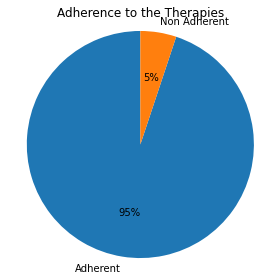

In [41]:
counts = data.groupby(["Adherent_Flag"]).Adherent_Flag.count()
counts.plot.pie(y=counts.index,autopct='%1.0f%%',startangle=90,ylabel="",labels=["Adherent","Non Adherent"], title="Adherence to the Therapies",figsize=(4,4))
plt.axis('equal')
plt.tight_layout()
plt.show()

### Comorbidity Plot

In [42]:
comorbidity_data = data_obj_train.iloc[:,21:35]
comorbidity_data.dtypes

comorb_data = data_obj_train.columns[21:35]

counts = pd.DataFrame()
for x in comorb_data[0:len(comorb_data)]:
    counts[x]=comorbidity_data.groupby([x]).size().to_frame()

counts = counts.rename(columns = lambda x: x.strip('Comorb'))
counts = counts.rename(columns = lambda x: x.strip('_'))

counts = counts.transpose()
counts = counts.sort_values('Y',ascending=False)

labels = list(counts.index)

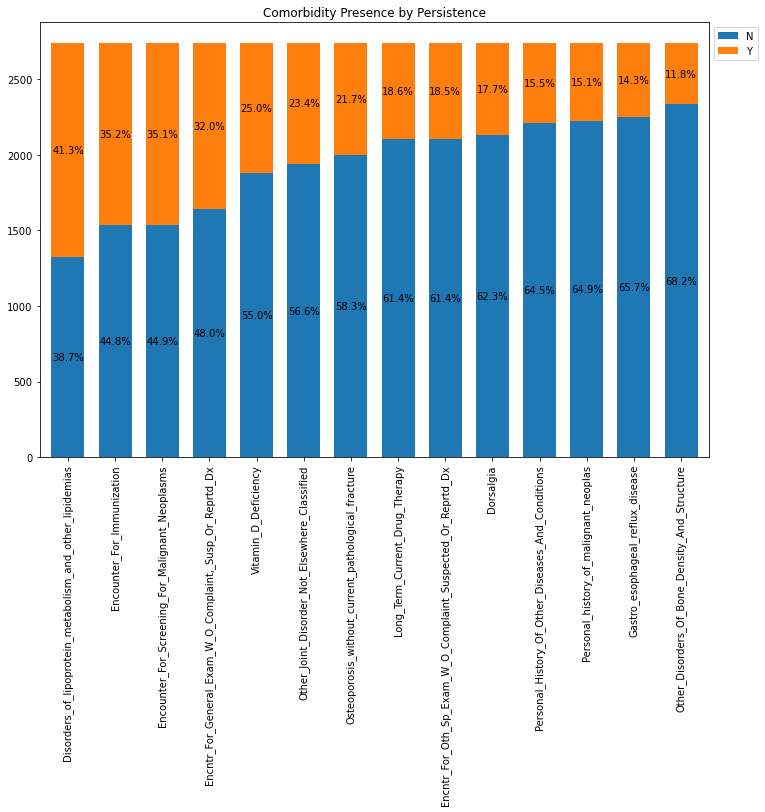

In [43]:
X_axis = np.arange(len(labels))
ax = counts.plot(stacked=True, kind='bar',width=0.7, figsize=(12, 8), rot='horizontal')

plt.xticks(X_axis, labels,rotation=90)
for rect in ax.patches:
    
    height = rect.get_height()
    
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    
    label_text = f'{round((height/3424)*100,1)}%'  
    
    
    label_x = x + width / 2
    label_y = y + height / 2
    
    
    if height > 0:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=10)
    
ax.legend(title = '',bbox_to_anchor=(1.0, 1.0)) 
plt.title("Comorbidity Presence by Persistence")  
plt.show()

### Concomitancy Plot

In [44]:

concomitancy_data = data_obj_train.iloc[:,35:45]
concomitancy_data.dtypes

concom_data = data_obj_train.columns[35:45]


counts = pd.DataFrame()
for x in concom_data[0:10]:
    counts[x]=concomitancy_data.groupby([x]).size().to_frame()
    
counts = counts.rename(columns = lambda x: x.strip('Concom'))
counts = counts.rename(columns = lambda x: x.strip('_'))

counts = counts.transpose()
counts = counts.sort_values('Y',ascending=False)

labels = list(counts.index)

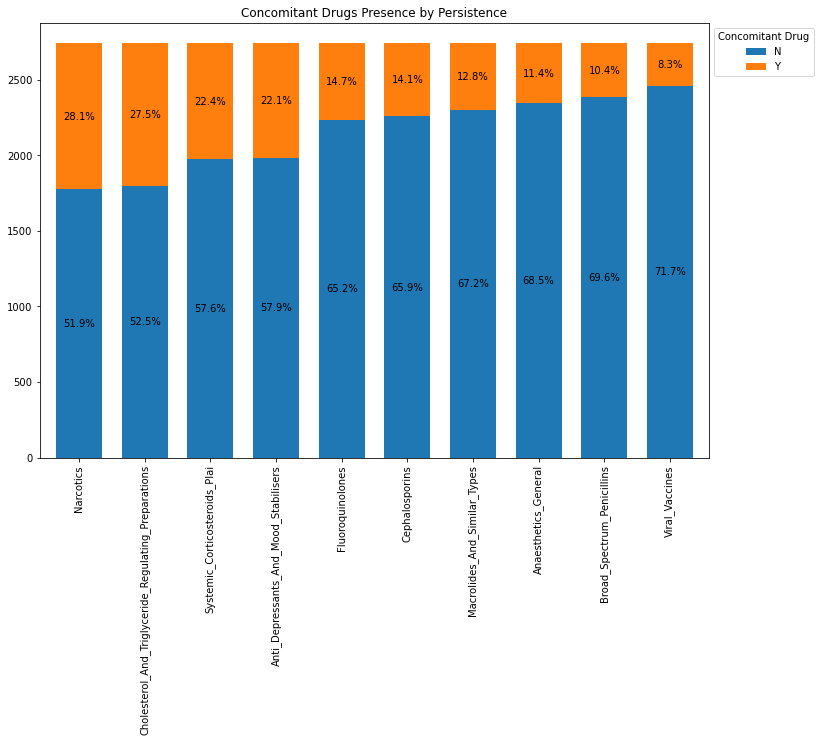

In [45]:
X_axis = np.arange(len(labels))
ax = counts.plot(stacked=True, kind='bar',width=0.7, figsize=(12, 8), rot='horizontal')

plt.xticks(X_axis, labels,rotation=90)
for rect in ax.patches:
    
    height = rect.get_height()
    
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    
    label_text = f'{round((height/3424)*100,1)}%'  
    
    
    label_x = x + width / 2
    label_y = y + height / 2
    
    
    if height > 0:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=10)
    
ax.legend(title = 'Concomitant Drug',bbox_to_anchor=(1.0, 1.0)) 
plt.title("Concomitant Drugs Presence by Persistence")  
plt.show()